#Artificial Neural Networks and Deep Learning  



##Assignment 3.2 - Convolutional Neural Networks

Prof. Dr. Ir. Johan A. K. Suykens     

In this file, we will implement a convolutional neural network from scratch.

We only consider classification tasks here in the session.




In [1]:
# Please first load your google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Please go to Edit > Notebook settings > Hardware accelerator > choose "T4 GPU"
# Now check if you have loaded the GPU successfully
!nvidia-smi

Sat Apr  6 20:13:00 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8               8W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Convolutional Neural Networks
In this section, we implement CNN from scrath and train it on the MNIST dataset.

We first load the dataset as follows:

In [3]:
import torch
from torch import nn, optim, functional, utils
from torch.utils.data.dataloader import DataLoader
import torchvision
from torchvision import datasets, utils
from torchvision.datasets import MNIST

import time, os

import matplotlib.pyplot as plt
# use seaborn
import seaborn as sns

# Apply the default theme
sns.set_theme()
plt.rcParams["figure.dpi"] = 100
plt.rcParams['savefig.dpi'] = 300


def get_mnist_loader(batch_size=100, num_train_samples = 10000, num_test_samples = 2000):
    """

    :return: train_loader, test_loader
    """
    train_dataset = MNIST(root='../data',
                          train=True,
                          transform=torchvision.transforms.ToTensor(),
                          download=True)
    test_dataset = MNIST(root='../data',
                         train=False,
                         transform=torchvision.transforms.ToTensor(),
                         download=True)

    # Randomly select a subset of samples
    train_indices = torch.randperm(len(train_dataset))[:num_train_samples]
    test_indices = torch.randperm(len(test_dataset))[:num_test_samples]

    # Create subset samplers to be used in the dataloader
    train_subset_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
    test_subset_sampler = torch.utils.data.SubsetRandomSampler(test_indices)

    train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                               batch_size=batch_size,
                                               sampler = train_subset_sampler)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                              batch_size=batch_size,
                                              sampler = test_subset_sampler)


    return train_loader, test_loader

## Build CNN from scratch
Our CNN is of 4 convolutional layers and 2 fully connected layers.
You can try a different amount of layers by simply add more ``self.conv`` layers inside  ``__init__`` and ``forward`` in the following code. Please be careful with the dimensions of the convolutional layers when changing parameters such as convolution channels, kernel_size and stride.

In [4]:
class CNNnet(torch.nn.Module):
    def __init__(self):
        super(CNNnet,self).__init__()
        self.conv1 = torch.nn.Sequential(
            # 2-D convolution
            torch.nn.Conv2d(in_channels=1, # input channels
                            out_channels=16, # convolution channels
                            kernel_size=3, # kernel size of the convolution
                            stride=2, # stride of the kernel
                            padding=1), # padding with 0
            # Data is normalized before entering ReLU，num_features=batch_size*num_features*height*width
            # Output is with size (N,C,W,H), i.e., (batch_size, channels, width, height)
            torch.nn.BatchNorm2d(16), # the input dimensionality of BatchNorm2d should match the number of convolution channels
            # Set activation function
            torch.nn.ReLU()
        )
        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(16,32,3,2,1), # be sure to have the number of input channels match the output channels of the previous layer
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU()
        )
        self.conv3 = torch.nn.Sequential(
            torch.nn.Conv2d(32,32,3,2,1),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU()
        )
        self.conv4 = torch.nn.Sequential(
            torch.nn.Conv2d(32,64,2,2,0),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU()
        )
        # set fully connected layer
        self.mlp1 = torch.nn.Linear(2*2*64,100) # input dimension should match the output dimension from the previous layer
        # final output is of dimension 10 since
        # MNIST is a 10-class classification dataset
        self.mlp2 = torch.nn.Linear(100,10)

    # feedforward
    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        # flatten tensor to 1-D
        x = self.mlp1(x.view(x.size(0),-1))
        x = self.mlp2(x)
        return x

## Training function
The training process includes loading the model, setting the optimizer, and running on the training set for epochs.
After each training epoch, we evaluate the model on the test set to record the test accuracy.

In [5]:
def train(model, train_epoch, model_save, train_loader, test_loader) :
    # Push model on to GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    loss_func = nn.CrossEntropyLoss( )
    # Use Adam optimizer
    optimizer = torch.optim.Adam(model.parameters( ),lr=0.001)

    acc_count = []  # record the test accuracy
    for epoch in range(train_epoch):

        model.train()

        for i, (x, y) in enumerate(train_loader):
            x = x.to(device)  # torch,Size([128,1,28,28])
            y = y.to(device)   # torch.Size([128])
            # Output of the model
            out = model(x)  # torch.Size([128,10])
            # Compute loss
            loss = loss_func(out, y)

            optimizer.zero_grad()
            loss.backward()  # backpropagation
            optimizer.step()  # update the network parameters

            # save the model checkpoint every 20 iterations
            if i % 20 == 0:
                print('Training Loss:{:.6f} Batch {}/{} '.format(loss.item(), i, len(train_loader)))
                torch.save(model, model_save)

        # evaluate the model after each training epoch
        with torch.no_grad():
            model.eval()

            true_pred = torch.zeros(1).to(device)
            nb_sample = 0

            for inputs, targets in test_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                outputs = model(inputs)

                _, pred = torch.max(outputs, dim=1)

                true_pred = true_pred + torch.sum(pred == targets).type(torch.FloatTensor)
                nb_sample += len(inputs)

            acc = true_pred / nb_sample
            acc = acc.item()

            acc_count.append(acc)

            print('Epoch {:d}, Test Accuracy {:.3f} %'.format(epoch, acc * 100))

    return acc_count

## Let's start training!
The network is trained for 20 epochs, batch size of 100.

You can adjust the hyperparameters here if necessary.

In [6]:
# You can adjust the hyperparameters here if needed
train_epoch = 20
batch_size = 100
shuffle = True

# Define model
model = CNNnet()

# where to save the model
model_save = './MNIST_CNN/ckpt.pth'

import os
if not os.path.exists('MNIST_CNN'):
    os.mkdir('MNIST_CNN')

In [7]:
# load datasets
train_loader, test_loader = get_mnist_loader(batch_size=batch_size)

# train the model
acc_count = train(model, train_epoch=train_epoch, model_save=model_save, train_loader=train_loader, test_loader=test_loader)

100%|██████████| 9912422/9912422 [00:00<00:00, 119421705.06it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 103182022.00it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 31044288.62it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 21772032.88it/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw

Training Loss:2.322615 Batch 0/100 
Training Loss:0.805426 Batch 20/100 
Training Loss:0.450881 Batch 40/100 
Training Loss:0.234615 Batch 60/100 
Training Loss:0.132075 Batch 80/100 
Epoch 0, Test Accuracy 96.200 %
Training Loss:0.145678 Batch 0/100 
Training Loss:0.202931 Batch 20/100 
Training Loss:0.061244 Batch 40/100 
Training Loss:0.126431 Batch 60/100 
Training Loss:0.063578 Batch 80/100 
Epoch 1, Test Accuracy 97.100 %
Training Loss:0.095710 Batch 0/100 
Training Loss:0.044852 Batch 20/100 
Training Loss:0.082029 Batch 40/100 
Training Loss:0.035364 Batch 60/100 
Training Loss:0.090720 Batch 80/100 
Epoch 2, Test Accuracy 96.850 %
Training Loss:0.090433 Batch 0/100 
Training Loss:0.057535 Batch 20/100 
Training Loss:0.045033 Batch 40/100 
Training Loss:0.025713 Batch 60/100 
Training Loss:0.027929 Batch 80/100 
Epoch 3, Test Accuracy 97.700 %
Training Loss:0.030875 Batch 0/100 
Training Loss:0.006791 

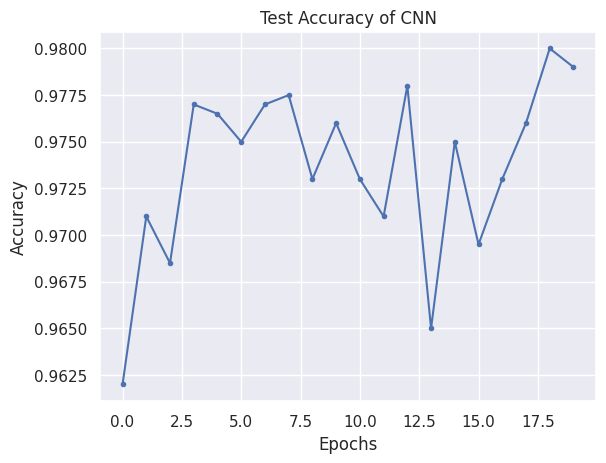

In [8]:
# Plot the accuracy curves w.r.t. epochs
plt.plot(acc_count, marker='.')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.title('Test Accuracy of CNN')
plt.show()

## CNN Parameters Experiment

To explore the outlined experiments within the provided CNN architecture for the MNIST dataset, let's update the code to reflect these experiments. This involves modifying the `CNNnet` class to make it more flexible, allowing for easy adjustments to layers, filter sizes, kernel sizes, incorporation of pooling layers, and experimentation with activation functions and batch normalization.

### Notes on the Updated Code:
- **Number of Convolutional Layers & Filters**: The constructor now accepts `num_conv_layers` and `filters`, allowing you to specify the number of convolutional layers and the number of filters in each layer.
- **Kernel Sizes**: You can specify `kernel_sizes` for each convolutional layer to explore the impact of different kernel sizes.
- **Activation Functions**: The `activation` parameter allows you to switch between different activation functions (`'relu'`, `'leaky_relu'`, `'tanh'`).
- **Batch Normalization**: The `use_batch_norm` boolean controls the use of batch normalization after each convolutional layer.
- **Pooling Layers**: The `use_pooling` list specifies which convolutional layers are followed by a MaxPooling layer.
- **Fully Connected Layers**: The size of the input to the first fully connected layer (`self.mlp1`) may need adjustment based on the architecture of your convolutional layers and the inclusion of pooling layers.

### Experimenting with the Network:
To experiment with different configurations, you can instantiate the `CNNnet` class with different parameters. For example, to create a network with 5 convolutional layers, more filters, and LeakyReLU activation functions without batch normalization, you could do:

```python
model = CNNnet(num_conv_layers=5, filters=[16, 32, 64, 128, 256], kernel_sizes=[3, 5, 3, 3, 3], activation='leaky_relu', use_batch_norm=False, use_pooling=[True, False, True, False, True])
```

### Running the Experiments:
To run the experiments, you'll need to adjust the parameters according to the experiments you're interested in and train the model. Since the performance and behavior of the network can vary significantly with these changes, it's crucial to carefully monitor the training process, check for signs of overfitting or underfitting, and possibly adjust the learning rate or the training duration accordingly.

In [9]:
class CNNnet(torch.nn.Module):
    def __init__(self, num_conv_layers=4, filters=[16, 32, 64, 128], kernel_sizes=[3, 3, 3, 3], activation='relu', use_batch_norm=True, use_pooling=[False, True, False, True]):
        super(CNNnet, self).__init__()
        layers = []

        in_channels = 1  # MNIST images are in grayscale
        for i in range(num_conv_layers):
            layers.append(torch.nn.Conv2d(in_channels, filters[i], kernel_size=kernel_sizes[i], stride=1, padding=kernel_sizes[i]//2))
            if use_batch_norm:
                layers.append(torch.nn.BatchNorm2d(filters[i]))
            if activation == 'relu':
                layers.append(torch.nn.ReLU())
            elif activation == 'leaky_relu':
                layers.append(torch.nn.LeakyReLU())
            elif activation == 'tanh':
                layers.append(torch.nn.Tanh())
            if use_pooling[i]:
                layers.append(torch.nn.MaxPool2d(kernel_size=2, stride=2))
            in_channels = filters[i]

        self.conv_layers = torch.nn.Sequential(*layers)

        # Adjust the size below based on your final layer output after convolutions and optional pooling
        self.mlp1 = torch.nn.Linear(filters[-1] * 7 * 7, 128)  # Example for the first FC layer
        self.mlp2 = torch.nn.Linear(128, 10)  # MNIST has 10 classes

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten the output for the FC layers
        x = torch.nn.functional.relu(self.mlp1(x))
        x = self.mlp2(x)
        return x


In [10]:
model = CNNnet(num_conv_layers=5, filters=[16, 32, 64, 128, 256], kernel_sizes=[3, 5, 3, 3, 3], activation='leaky_relu', use_batch_norm=False, use_pooling=[True, False, True, False, True])


In [12]:
# You can adjust the hyperparameters here if needed
train_epoch = 20
batch_size = 100
shuffle = True

# Define model
model = CNNnet()

# where to save the model
model_save = './MNIST_CNN/ckpt_v2.pth'

import os
if not os.path.exists('MNIST_CNN'):
    os.mkdir('MNIST_CNN')

# load datasets
train_loader, test_loader = get_mnist_loader(batch_size=batch_size)

# train the model
acc_count = train(model, train_epoch=train_epoch, model_save=model_save, train_loader=train_loader, test_loader=test_loader)

Training Loss:2.348467 Batch 0/100 
Training Loss:0.699602 Batch 20/100 
Training Loss:0.215621 Batch 40/100 
Training Loss:0.070554 Batch 60/100 
Training Loss:0.152414 Batch 80/100 
Epoch 0, Test Accuracy 94.950 %
Training Loss:0.068293 Batch 0/100 
Training Loss:0.035506 Batch 20/100 
Training Loss:0.050653 Batch 40/100 
Training Loss:0.132257 Batch 60/100 
Training Loss:0.058451 Batch 80/100 
Epoch 1, Test Accuracy 96.950 %
Training Loss:0.065299 Batch 0/100 
Training Loss:0.039654 Batch 20/100 
Training Loss:0.086638 Batch 40/100 
Training Loss:0.096029 Batch 60/100 
Training Loss:0.053845 Batch 80/100 
Epoch 2, Test Accuracy 97.400 %
Training Loss:0.037662 Batch 0/100 
Training Loss:0.023793 Batch 20/100 
Training Loss:0.040742 Batch 40/100 
Training Loss:0.024525 Batch 60/100 
Training Loss:0.017350 Batch 80/100 
Epoch 3, Test Accuracy 98.500 %
Training Loss:0.010714 Batch 0/100 
Training Loss:0.015622 Batch 20/100 
Training Loss:0.005086 Batch 40/100 
Training Loss:0.022898 Bat

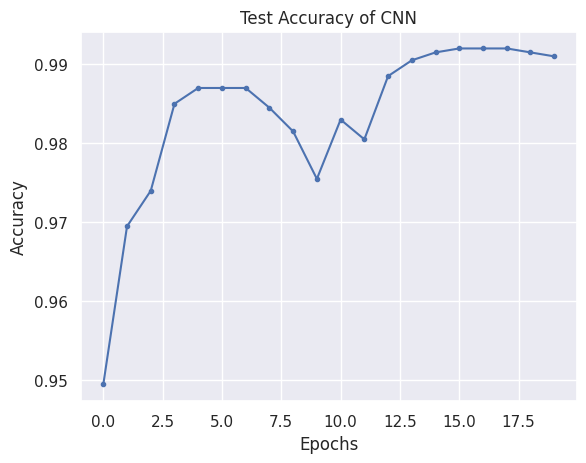

In [13]:
# Plot the accuracy curves w.r.t. epochs
plt.plot(acc_count, marker='.')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.title('Test Accuracy of CNN')
plt.show()